# Project: Finding Donors for *CharityML*

## Problem Description

In this project, implementation of several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census will be done. Then the best candidate algorithm from preliminary results will be choosen and further optimize this algorithm to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income']=='>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income']=='<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100*float(n_greater_50k)/float(n_records)

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

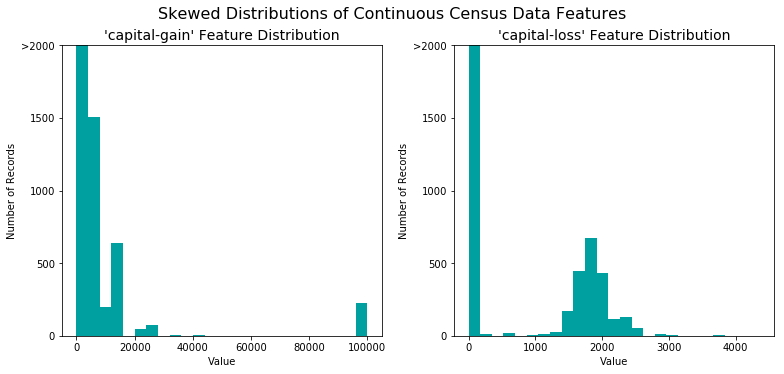

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

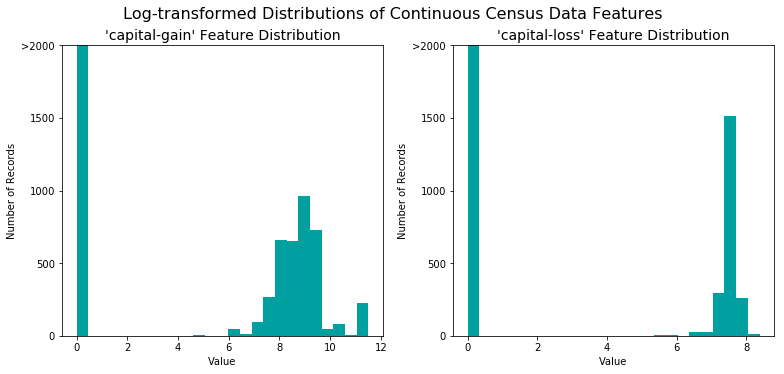

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = pd.get_dummies(income_raw)
income = pd.DataFrame((0*income['<=50K']+income['>50K']))
income.columns = ['>50']
# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded


103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])



Training set has 36177 samples.
Testing set has 9045 samples.


/home/atrij/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# TODO: Calculate accuracy
accuracy = float(n_greater_50k/float(n_records))

# TODO: Calculate F-score using the formula above for beta = 0.5
# recall=1 , precision = accuracy
fscore = (1+ (0.5*0.5))*accuracy/((0.5*0.5*accuracy)+1)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


# **Answer: ** 
***
* **Accuracy** : 0.2478
* **F-Score** : 0.2917

*****


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **
*****
- <a href="http://rob.schapire.net/papers/explaining-adaboost.pdf">**AdaBoost**</a>: 
    * **Real-world application** : *Real-time Face Detection*, 
        * source : <a href="https://pdfs.semanticscholar.or/4e54/6c43e5642ecdffd000406f0b35c1e3430a2c.pdf">Algorithms for Real-Time Object Detection in Images </a> - by MILOS STOJMENOVIC 
    * **Strengths of the model** :
        1. AdaBoost can achieve good classification results with much less tweaking of parameters or settings
        2. Computationally efficient
        3. Versatile - a wide range of base learners can be used with AdaBoost
        4. It comes with a set of theoretical guarantees given sufficient data and a weak learner that can reliably provide only moderately accurate weak hypothese
        5. Ability to handle Unbalanced data
    * **When does it perform well?**:
         1. The complexity of weak learner should sit the classification problem. Highly complex weak learner can cause overfitting.
    * **Weaknesses of the model** :
         * AdaBoost can be sensitive to noisy data and outliers. Reason : it is fitting a classification model (an additive model) to an exponential loss function, and the exponential loss function is sensitive to outliers/label noise.  
    * **When does it perform poorly ?**
         1. Boosting can fail to perform well given insufficient data
         2. overly complex weak hypotheses
         3. AdaBoost performance can be very poor when the weak hypotheses are insufficiently expressive
    * **What makes this model a good candidate for the problem, given what you know about the data?**
        * Given data has **features of mixed type (categorical and continuous)**. Boosting algorithms in general handle data of mixed type well. Hence, adaboost is a good choice
        * Boosting algorithms work iteratively, in each next iterations the examples previously ill-classified are given more importance in minimisation of loss function of that current iteration .This property of boosting algorithms enables it to handle unbalanced data better.
        Dateset at hand is imbalanced , '>50K' :24.78%. Also as part of construction of problem we are considering F-beta score as our metric, due to which whe interest usually leans towards correct classification of the “rare” class (which we will refer to as the “positive” class). 
******
- **Gradient Boosting**: 
    * **Real-world application** : *EMG robotic ARM controller: building a regression model to map the EMG signals to the robotic hand controller*, 
        * source : <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/">Gradient boosting machines, a tutorial</a>  
    * **Strengths of the model** :
        1. Natural handling of data of mixed type (= heterogeneous features)
        2. Predictive power
        3. Robustness to outliers in output space (via robust loss functions)
        4. Handles unbalanced dataset better
    * **When does it perform well?**:
         1. For algorithm to work properly, an appropriate loss function is to be provided
    * **Weaknesses of the model** :
         * Scalability, due to the sequential nature of boosting it can hardly be parallelized
         * Gradient bossting algorithm has many parameters to tune
    * **When does it perform poorly ?**
         1. Untuned GBM model performs worse than Random Forest in certain cases
    * **What makes this model a good candidate for the problem, given what you know about the data?**
        * Argument given for suitability of Adaboost still holds for Gradient Boost
        * In income data there are bound to be outliers, so a robust loss function can be used in Gradient boost to overcome diificulty in classification due to outliers
********
- **Random Forest**: 
    * **Real-world application** : *Fault detection in Mechanical equipments*, 
        * source : <a href="http://www.j-mst.org/On_line/admin/files/09-08335_1716-1725_.pdf">Random forests classifier for machine fault diagnosis  - by Bo-Suk Yang, Xiao Di and Tian Han</a>  
    * **Strengths of the model** :
        1.  Considering that Random Forests have few parameters to tune and can be used simply with default parameter settings, they are a simple tool to use without having a model or to produce a reasonable model fast and efficiently.
        2. It has methods for balancing error in class population unbalanced data sets. 
        3. Parallel processing can be achieved
        4. It runs efficiently on large databases
        5. Random Forests perform implicit feature selection and provide a pretty good indicator of feature importance.
        6. It’s really hard to build a bad Random Forest! Since random forests are not very sensitive to the specific hyper-parameters used, they don’t require a lot of tweaking and fiddling to get a decent model, just use a large number of trees and things won’t go terribly awry. Most Random Forest implementations have sensible defaults for the rest of the parameters.
        7.  Random Forests can be easily grown in parallel. The same cannot be said about boosted models or large neural networks.

    * **When does it perform well?**:
         1. It works well in almost all kind of datasets.
    * **Weaknesses of the model** :
         1. The main drawback of Random Forests is the model size. You could easily end up with a forest that takes hundreds of megabytes of memory and is slow to evaluate.
         2. Low interpretability of learned model as compared to decision tree
  
    * **When does it perform poorly ?**
         1. They don’t do well at all when you require extrapolation outside of the range of the dependent (or independent) variables 
    * **What makes this model a good candidate for the problem, given what you know about the data?**
        * The data provided consists of **variables of mixed type**, Random Forest can easily handle such data
        * The number of features avialable in data is large(103).Random forest algo has **implicit feature selection** ,due to random nature of feature selection at each splitting node. Hence, while using RF we dont need to implement feature selection step.
        * The data collected can have much outliers, rationale behind this assertion is, that there are certain individuals who beat the odds . Consider the following example
       *****
       Ex. consider just the following attribute/traits of a random person X:
            - Studied upto 4th
            - Age:20
            - income : 62000
       ****
      Using common understanding of how world works it's reasonable to say that, there won't be many people having same atrributes as that of X and earning more than 50K. Most of such people would be earning less than 50K. Hence this sample can be considered outliers. Such cases are present in a plenty in the dataset (look at the illustration below). 
      Random forest resamples data for training its constituent trees, this nature in algorithms provides robustness towards outliers.
      

### Illustration of outliers in data
 ##### Case 1 ( low education-high income):
  A person having less education would certainly be considered an outlier if he is earning more than 50 K. Below a count of 31 is obtained for people having education-num less than 4 and belonging to higher income group

In [26]:
print 'count of people with educatio-num less than 4 (very less educated) earning more than 50K:',data[data['income'] == '>50K'][data['education-num']<4].count()[0]

count of people with educatio-num less than 4 (very less educated) earning more than 50K: 31


/home/atrij/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


 ##### Case 2 ( Low age-high income):
  A person having age in early 20's would certainly be considered an outlier if he is earning more than 50 K. Below a count of 24 is obtained for people having age less than 23 and belonging to higher income group.

In [25]:
a= len(data[data['income'] == '>50K'][data['age']<23].index)
print 'count of people with educatio-num less than 4 (very less educated) earning more than 50K:',a

count of people with educatio-num less than 4 (very less educated) earning more than 50K: 24


/home/atrij/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[0:sample_size],y_train[0:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[0:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[0:300],predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

In [10]:
rand=10

/home/atrij/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.


/home/atrij/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


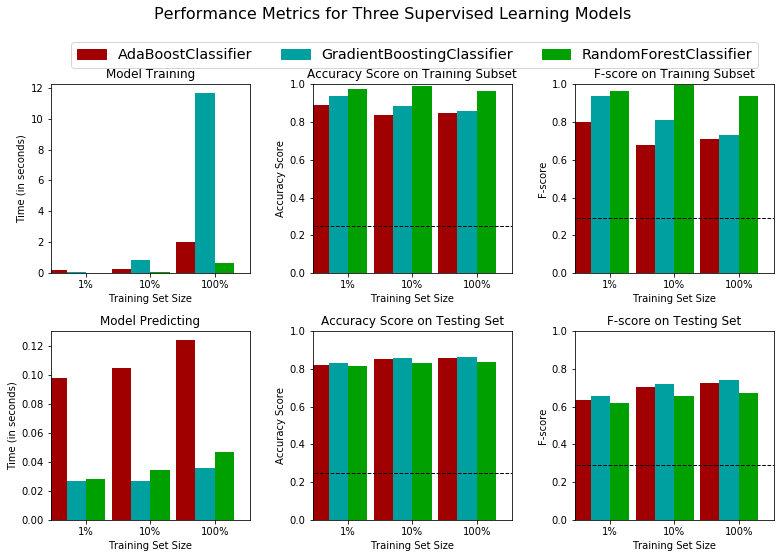

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Initialize the three models
clf_A = AdaBoostClassifier(random_state=rand)
clf_B = RandomForestClassifier(random_state=rand)
clf_C = GradientBoostingClassifier(random_state=rand)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(0.01*len(X_train))
samples_10 = int(0.1*len(X_train))
samples_100 = int(1*len(X_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [19]:
print results['AdaBoostClassifier'][2]


{'pred_time': 0.13572096824645996, 'f_test': 0.72455089820359275, 'train_time': 2.870043992996216, 'acc_train': 0.84999999999999998, 'acc_test': 0.85760088446655613, 'f_train': 0.71153846153846156}


In [12]:
print results['GradientBoostingClassifier']

{0: {'pred_time': 0.02654290199279785, 'f_test': 0.65833785985877247, 'train_time': 0.09194016456604004, 'acc_train': 0.93999999999999995, 'acc_test': 0.83073521282476503, 'f_train': 0.9375}, 1: {'pred_time': 0.027151107788085938, 'f_test': 0.72160405420293039, 'train_time': 0.8645949363708496, 'acc_train': 0.8833333333333333, 'acc_test': 0.85594250967385299, 'f_train': 0.81349206349206349}, 2: {'pred_time': 0.035676002502441406, 'f_test': 0.7395338561802719, 'train_time': 11.631297826766968, 'acc_train': 0.85666666666666669, 'acc_test': 0.86301824212271971, 'f_train': 0.73412698412698407}}


In [13]:
print results['RandomForestClassifier']

{0: {'pred_time': 0.028018951416015625, 'f_test': 0.61630447280671496, 'train_time': 0.03068399429321289, 'acc_train': 0.97333333333333338, 'acc_test': 0.81381978993919291, 'f_train': 0.96726190476190466}, 1: {'pred_time': 0.03474903106689453, 'f_test': 0.65564858105904111, 'train_time': 0.061698198318481445, 'acc_train': 0.99333333333333329, 'acc_test': 0.82962962962962961, 'f_train': 0.99431818181818166}, 2: {'pred_time': 0.04699206352233887, 'f_test': 0.67075022780196425, 'train_time': 0.6802561283111572, 'acc_train': 0.96333333333333337, 'acc_test': 0.83714759535655059, 'f_train': 0.94117647058823517}}


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **
***
**Gradient Boosting Classifier** is most appropriate for the task of identifying individuals that make more than dollar 50,000

* **Model Performance** : The metric used to measure model performance is Fbeta score with Beta=0.5 , hence placing more importance on precision, as model's ability to precisely predict those that make more than dollar 50,000 is more important than the model's ability to recall those individuals. For Gradient Boosting Classifier F_beta score is **73.95%**.

* **Prediction/Training Time** : 
    * **Training time** : Training time is **14.31**  seconds, higher than other classifiers considered. But, for the required application training time doesn't matter much as it's to be done once as training data is fixed
    * **Prediction Time** : Prediction time is **0.036** seconds for 300 examples, which significantly lower than other classifiers. Low prediction time is important for the application at hand as suitable donors are to be selected from a vast database of potential people. So a quick predictor would make the process of selection fast.

* **Generalisation** : It can be seen that, RF is producing high scores on Training and low on Test, this means its overfitting. While Gradient boost has comparable test and train scores, indicating that it gneralises well

* **Size of Training Set** : On comparing the model performance in case of 1%, 10% and 100% training data case. It is observed that Fscore on test data hasn't increased much from 10% to 100% case ( by about 0.01). Therefore, it indicates that we are working with appropriate data-size.


* **Algorithm's suitability for the data** : 
    * Robustness to outliers : Gradient boosting is robust to outliers as it uses loss function. In the data provided there are several outliers. There are cases where the occupation type doesn't match the income people are generating. Ex. for ccupation = "handlers and cleaners" most people earn less than 50K which also quite natural, but data shows there are 135 people earning more than 50K with above mentioned occupation (reffer the cell below)
    * Natural handling of data of mixed type : The data provided has festures of mixed datatype ( categorical + real valued). The algorithm suggested has natural handling power for mixed data types
    
    
    

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 
****
Model consists of following procedural elements performed sequencially,:
1. **Data-preprocessing** : The data , that is provided,is to re-conditioned to suit the internal machinery of the learning and decision making engine of model. Data-preprocessing step performs this reconditioning. 
3. **Training Gradient Boosting Classifier**: Once the data is re-conditioned, it can be used to train the learner.
    * *how the model is trained?* : A GBM learns multiple weak capability models. By weak capability it's meant that these learners are slightly better in accuracy than random guessing. Ex. consider a binary classification problem. By random guessing we can obtain error rate of 50%. Suppose we have a learner that learns an error rate of 40%. Such a learner is slightly better than random guessing. The methodology used by GBM to learn these weak learners is what makes GBM training special. 
    GBM learns a weak learner in first iteration, then analyses the error obtained with respect to this model. The residual obtained after first step is then used to fit another model that fits the residuals. Each of these models are then added after multiplication with necessary weights. This additive model is new model, now residuals are again computer and so on 
4. **Prediction using trained model on unseen data** : The final prediction is made by weighted average of prediction made by each individual models  constituent of the additive model discussed above



### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [18]:
# converting y_train to pandas series so that crossvalidation function doesn't pop index error
y_train=y_train['>50']

** Grid Search Strategy**
*****
using the approach provided in blog *https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/* for tuning of gradient boosting machines
*****
In GBM boosting there are 2 categories of parameters that are to be tuned:
* **Boosting machine parameters** : n_estimators, learning_rate, sub_sample
* **Tree parameters** : max_depth, min_sample_split, max_features
*******
Approach for tackling the problem:
1. Decide a relatively higher value for learning rate and tune the number of estimators requried for that
2. Tune the tree specific parameters for that learning rate
3. Tune subsample
4. Lower learning rate as much as possible computationally and increase the number of estimators accordingly



In [23]:
#step:1

# tuning number of estimators

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.ensemble import GradientBoostingClassifier
# TODO: Initialize the classifier
clf = GradientBoostingClassifier(learning_rate=0.15, max_depth=5, min_samples_split= 90, min_samples_leaf=50, 
                                 max_features="sqrt",subsample=0.8,random_state=rand)

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':range(220,400,10)}   # choosing a range of n_estimators from 220 to 400 with step size 10

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring=scorer,verbose=5)


# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] n_estimators=220 ................................................
[CV] ....................... n_estimators=220, score=0.743749 -   7.6s
[CV] n_estimators=220 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] ....................... n_estimators=220, score=0.742488 -   8.3s
[CV] n_estimators=220 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.0s remaining:    0.0s


[CV] ....................... n_estimators=220, score=0.747693 -   7.6s
[CV] n_estimators=230 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.5s remaining:    0.0s


[CV] ....................... n_estimators=230, score=0.743054 -   8.1s
[CV] n_estimators=230 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   31.6s remaining:    0.0s


[CV] ....................... n_estimators=230, score=0.745850 -   7.8s
[CV] n_estimators=230 ................................................
[CV] ....................... n_estimators=230, score=0.749942 -   8.1s
[CV] n_estimators=240 ................................................
[CV] ....................... n_estimators=240, score=0.742604 -   8.3s
[CV] n_estimators=240 ................................................
[CV] ....................... n_estimators=240, score=0.744778 -   8.2s
[CV] n_estimators=240 ................................................
[CV] ....................... n_estimators=240, score=0.750097 -   8.3s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.742972 -   8.0s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.743792 -   8.1s
[CV] n_estimators=250 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  8.4min finished


Unoptimized model
------
Accuracy score on testing data: 0.8637
F-score on testing data: 0.7379

Optimized Model
------
Final accuracy score on the testing data: 0.8705
Final F-score on the testing data: 0.7515


## result after step-1##
n_estimators = **380**

In [26]:
# step2
# tuning tree parameters : min_sample_split, max_depth
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.ensemble import GradientBoostingClassifier
# TODO: Initialize the classifier
clf = GradientBoostingClassifier(learning_rate=0.15,n_estimators=380, min_samples_leaf=50, 
                                 max_features="sqrt",subsample=0.8,random_state=rand)

# TODO: Create the parameters list you wish to tune
parameters = {'min_samples_split':range(50,240,40),'max_depth':range(5,12,1)}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring=scorer,verbose=5)


# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] min_samples_split=50, max_depth=5 ...............................
[CV] ...... min_samples_split=50, max_depth=5, score=0.748353 -  10.6s
[CV] min_samples_split=50, max_depth=5 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] ...... min_samples_split=50, max_depth=5, score=0.741381 -  10.4s
[CV] min_samples_split=50, max_depth=5 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s


[CV] ...... min_samples_split=50, max_depth=5, score=0.754026 -  10.7s
[CV] min_samples_split=90, max_depth=5 ...............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.7s remaining:    0.0s


[CV] ...... min_samples_split=90, max_depth=5, score=0.748353 -  11.0s
[CV] min_samples_split=90, max_depth=5 ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   42.7s remaining:    0.0s


[CV] ...... min_samples_split=90, max_depth=5, score=0.741381 -  10.6s
[CV] min_samples_split=90, max_depth=5 ...............................
[CV] ...... min_samples_split=90, max_depth=5, score=0.754026 -  10.3s
[CV] min_samples_split=130, max_depth=5 ..............................
[CV] ..... min_samples_split=130, max_depth=5, score=0.746839 -  10.4s
[CV] min_samples_split=130, max_depth=5 ..............................
[CV] ..... min_samples_split=130, max_depth=5, score=0.741171 -  11.3s
[CV] min_samples_split=130, max_depth=5 ..............................
[CV] ..... min_samples_split=130, max_depth=5, score=0.753435 -  11.8s
[CV] min_samples_split=170, max_depth=5 ..............................
[CV] ..... min_samples_split=170, max_depth=5, score=0.746524 -  10.4s
[CV] min_samples_split=170, max_depth=5 ..............................
[CV] ..... min_samples_split=170, max_depth=5, score=0.744665 -  10.8s
[CV] min_samples_split=170, max_depth=5 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 30.2min finished


Unoptimized model
------
Accuracy score on testing data: 0.8676
F-score on testing data: 0.7447

Optimized Model
------
Final accuracy score on the testing data: 0.8690
Final F-score on the testing data: 0.7480


## Result after step2##
* **min_sample_split** : 210
* **max_depth** : 6

In [34]:
#step3
# tuning tree parameters : max_features
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.ensemble import GradientBoostingClassifier
# TODO: Initialize the classifier
clf = GradientBoostingClassifier(learning_rate=0.15,n_estimators=380, min_samples_split = 210,
                                 max_depth=6,min_samples_leaf=50,subsample=0.8,random_state=rand)

# TODO: Create the parameters list you wish to tune
parameters = {'max_features':range(8,35,1)}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring=scorer,verbose=5)


# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] max_features=8 ..................................................
[CV] ......................... max_features=8, score=0.743553 -  10.7s
[CV] max_features=8 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] ......................... max_features=8, score=0.736236 -  11.1s
[CV] max_features=8 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.8s remaining:    0.0s


[CV] ......................... max_features=8, score=0.751725 -  12.6s
[CV] max_features=9 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.4s remaining:    0.0s


[CV] ......................... max_features=9, score=0.749035 -  11.4s
[CV] max_features=9 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.9s remaining:    0.0s


[CV] ......................... max_features=9, score=0.740312 -  11.8s
[CV] max_features=9 ..................................................
[CV] ......................... max_features=9, score=0.752354 -  13.2s
[CV] max_features=10 .................................................
[CV] ........................ max_features=10, score=0.749943 -  12.4s
[CV] max_features=10 .................................................
[CV] ........................ max_features=10, score=0.740934 -  14.0s
[CV] max_features=10 .................................................
[CV] ........................ max_features=10, score=0.754819 -  14.8s
[CV] max_features=11 .................................................
[CV] ........................ max_features=11, score=0.742448 -  15.9s
[CV] max_features=11 .................................................
[CV] ........................ max_features=11, score=0.738903 -  14.9s
[CV] max_features=11 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 27.3min finished


Unoptimized model
------
Accuracy score on testing data: 0.8679
F-score on testing data: 0.7419

Optimized Model
------
Final accuracy score on the testing data: 0.8690
Final F-score on the testing data: 0.7480


## result after step-3 ##
* **max_feature** : 10

In [36]:
# tuning boosting parameters : subsample
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.ensemble import GradientBoostingClassifier
# TODO: Initialize the classifier
clf = GradientBoostingClassifier(learning_rate=0.15,n_estimators=380, min_samples_split = 210,
                                 max_depth=6,min_samples_leaf=50,max_features=10,random_state=rand)

# TODO: Create the parameters list you wish to tune
parameters = {'subsample':[0.6,0.65,0.7,0.75,0.8,0.85,0.90,0.95,1]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring=scorer,verbose=5)


# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] subsample=0.6 ...................................................
[CV] .......................... subsample=0.6, score=0.751006 -  12.3s
[CV] subsample=0.6 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV] .......................... subsample=0.6, score=0.741280 -  12.6s
[CV] subsample=0.6 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.9s remaining:    0.0s


[CV] .......................... subsample=0.6, score=0.753117 -  12.7s
[CV] subsample=0.65 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.6s remaining:    0.0s


[CV] ......................... subsample=0.65, score=0.747304 -  12.6s
[CV] subsample=0.65 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.2s remaining:    0.0s


[CV] ......................... subsample=0.65, score=0.741005 -  12.3s
[CV] subsample=0.65 ..................................................
[CV] ......................... subsample=0.65, score=0.750172 -  12.7s
[CV] subsample=0.7 ...................................................
[CV] .......................... subsample=0.7, score=0.747987 -  12.9s
[CV] subsample=0.7 ...................................................
[CV] .......................... subsample=0.7, score=0.736201 -  12.7s
[CV] subsample=0.7 ...................................................
[CV] .......................... subsample=0.7, score=0.751335 -  12.0s
[CV] subsample=0.75 ..................................................
[CV] ......................... subsample=0.75, score=0.745844 -  12.5s
[CV] subsample=0.75 ..................................................
[CV] ......................... subsample=0.75, score=0.742855 -  12.1s
[CV] subsample=0.75 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  5.4min finished


Unoptimized model
------
Accuracy score on testing data: 0.8702
F-score on testing data: 0.7503

Optimized Model
------
Final accuracy score on the testing data: 0.8702
Final F-score on the testing data: 0.7503


## result after step-4##
* **subsampe** : 1

In [45]:
# tuning boosting parameters : learning_rate
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.ensemble import GradientBoostingClassifier
# TODO: Initialize the classifier
clf = GradientBoostingClassifier(n_estimators=1500, min_samples_split = 210,
                                 max_depth=6,min_samples_leaf=50,max_features=10,subsample=1,random_state=rand)

# TODO: Create the parameters list you wish to tune
parameters = {'learning_rate':[0.05]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring=scorer,verbose=5)


# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.05 ..............................................
[CV] ..................... learning_rate=0.05, score=0.748734 -  40.1s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.1s remaining:    0.0s


[CV] ..................... learning_rate=0.05, score=0.741419 -  39.2s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ..................... learning_rate=0.05, score=0.759132 -  39.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min finished


Unoptimized model
------
Accuracy score on testing data: 0.8693
F-score on testing data: 0.7467

Optimized Model
------
Final accuracy score on the testing data: 0.8712
Final F-score on the testing data: 0.7524


# Result after step-5##
* **learning_rate**: 0.05
* **n_estimators** : 1500

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.2478              | 0.8630            |  0.8712         |
| F-score        | 0.2917              | 0.7395            |  0.7524         |


**Answer: **
*****
* What is your optimized model's accuracy and F-score on the testing data :
    * F-score: 0.7524
    * Accuracy Score: 0.8712
* Are these scores better or worse than the unoptimized model? **Yes**, optimised scores are better
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in Question 1? : optimised scores obtained are much better than the benchmark scores. 
    * F-score :  0.7524 compared to 0.2917
    * Accuracy: 0.8712 compared to o.2478

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

# 1. exploring importance of education number#
we would be looking at two graphs
* frequency plot of each education-number within each income class 
* boxplot of datapoints in each income class drawn against education-number to gain idea of central tendency

In [27]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

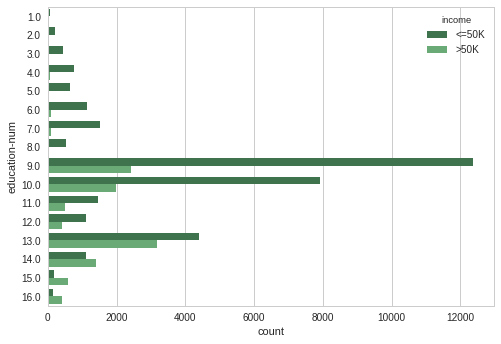

In [59]:
# importance of education-num:
sns.countplot(y="education-num", hue="income", data=data, palette="Greens_d")

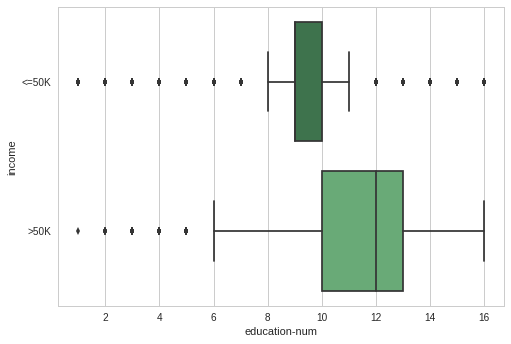

In [79]:
# importance education-num
sns.boxplot(y="income",x='education-num', data=data, palette="Greens_d")

### conclusion on importance of Education-num###
****
* Box-plot produced above displays the split created by education number in income classes. >50K classes have education number of about 12 while education class of people earning less than 50K have education number around 9
* There are cases where lower education numbers are earning more and higher education numbers earning less. Therefor other features are to be considered in conjunction with this feature
* important feature



# 2. exploring importance of Capital Gain#
we would be looking at two graphs
* Bar plot of capital-gain for each income-class

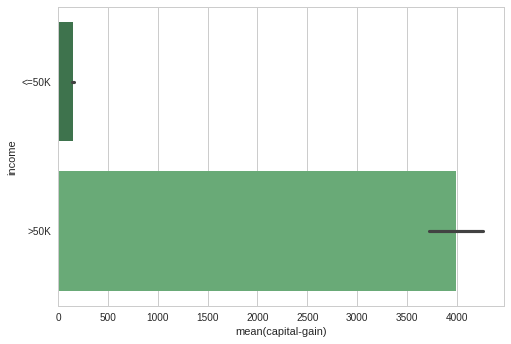

In [78]:
# importance capital-gain
sns.barplot(y="income",x='capital-gain', data=data, palette="Greens_d")

### conclusion on importance of Capital-Gain###
****
* It can be seen that capital-gain feature can be excusively used for classification as there is huge difference in mean values of capital gains for the two classes
* Important feature
****

# 3. exploring importance of Capital Loss#
we would be looking at two graphs
* Bar plot of capital-loss for each income-class

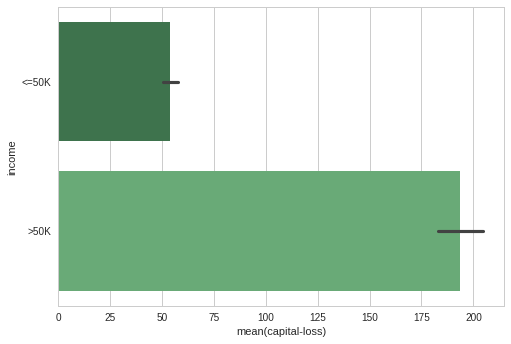

In [76]:
# importance of capital-loss
sns.barplot(y="income",x='capital-loss', data=data, palette="Greens_d")

### conclusion on importance of Capital-Loss###
****
* it can be seen that capital-loss feature can be used to for classification as there is vast difference between values of capital-gain for sample points belonging to the two classes. 
* Important feature
****

# 4. exploring importance of occupation#
we would be looking at following graphs
* frequency plot of each occupation for each income class

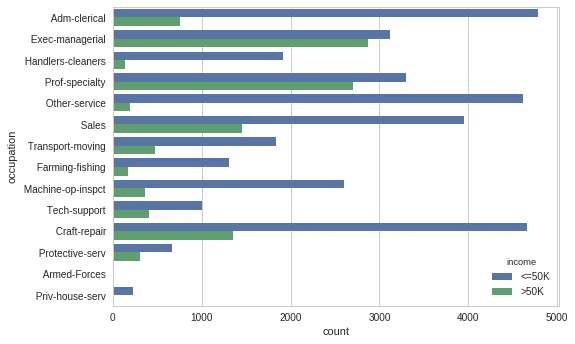

In [64]:
# importance of occupation
sns.countplot(y='occupation',hue='income',data=data)

### conclusion on importance of Occupation###
****
* Clearly all occupation have higher counts of income group less than 50K. Therefore this feature won't be useful in classification of positive class. This feature can be ignored
* Not important feature
******

# 5. exploring importance of Age#
we would be looking at following graphs
* Box-plot of age distribution in both income classes

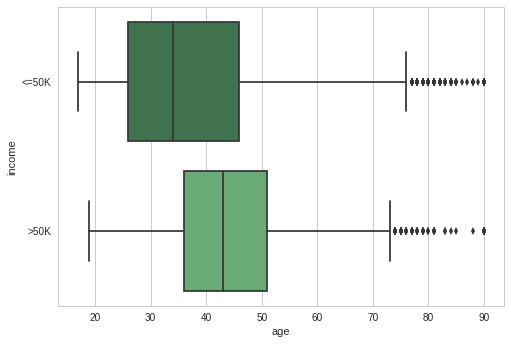

In [74]:
# importance of Age
sns.boxplot(y="income",x='age', data=data, palette="Greens_d")

### Conclusion on importance of Age###
****
* Looking at box plot , age of people earning more ythan 50K seem to be more than those earning less than 50K.
* this feature can be used in conjunction with other features to strenthen classification, and hence is an important feature
* Intuitively also this feature seems relevant. As, at higher paying positions generally more experienced people are present
* Important feature
******

# 6. exploring importance of Hours/week#
we would be looking at following graphs
* Box-plot of Hours/week distribution in both income classes

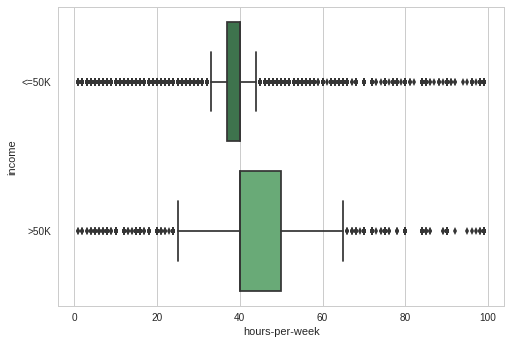

In [73]:
# importance marital status:
sns.boxplot(y="income",x='hours-per-week', data=data, palette="Greens_d")

### Conclusion on importance of hours/week###
****
* There is very narrow difference in values of hours/week
* This feature won't help in distinction between classes. Logically also, there are low paying jobs that demand heavy working hours. Such as transportation business
* not important
******

# 7. exploring importance of marital-status#
we would be looking at following graphs
* frequency plot of each marital status for each income group

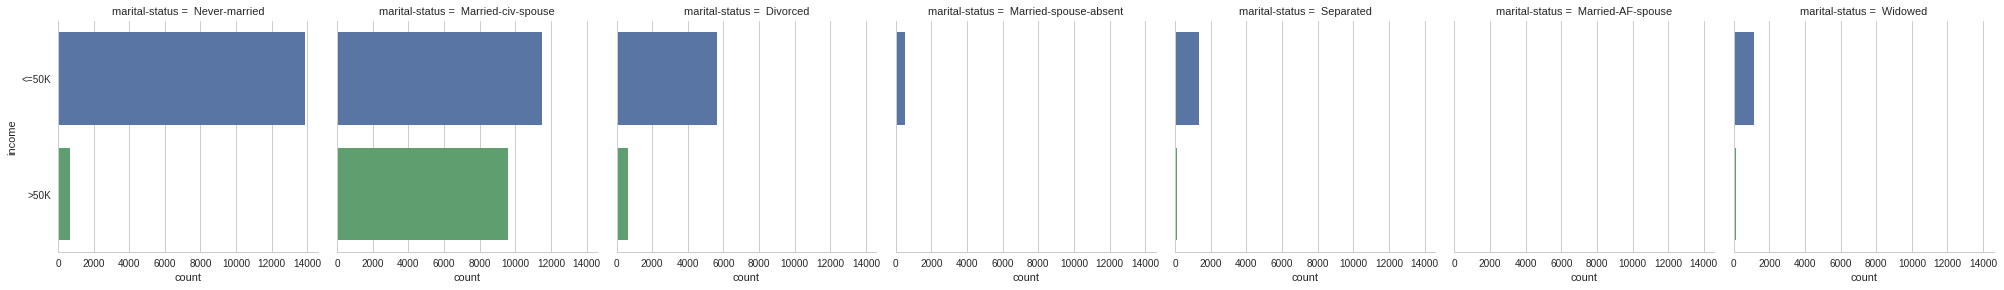

In [32]:
# importance marital-status
sns.factorplot(y="income",
               col="marital-status", data=data, kind="count")

### Conclusion on importance of marital-status###
****
* All marital status accept 'Married-Civ_spouse' are having dominantl count of <50k income group.
* Presence of marital-status with value 'Married-civ-spouse' indicates high possibility of >50k income groups, whereas if this feature has some other value the possibility of belonging to >50k income group drastically decreases
* important feature
******

# 8. exploring importance of workclass#
we would be looking at following graphs
* frequency plot of each marital status for each income group

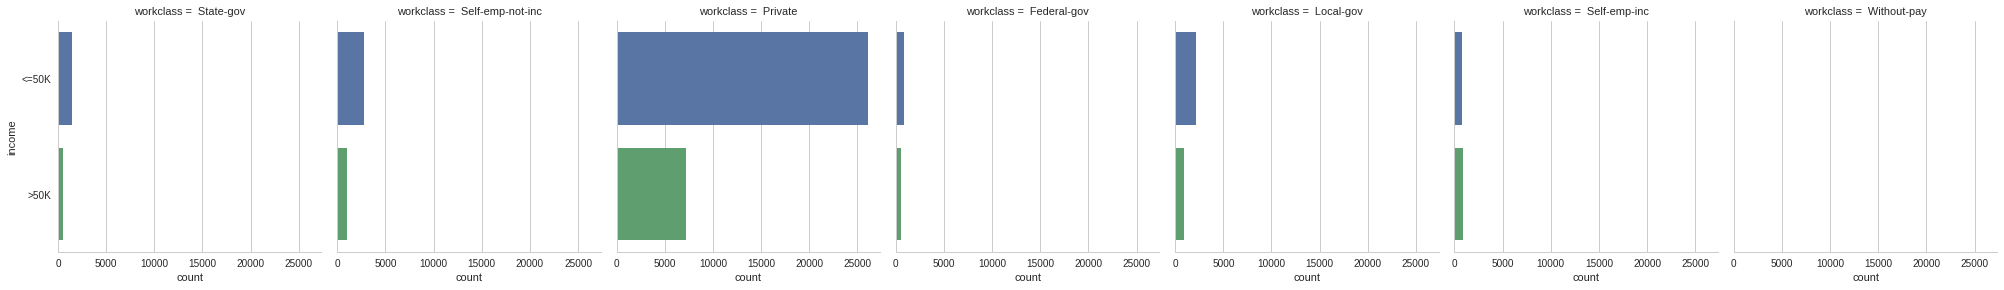

In [39]:
# importance workclass
sns.factorplot(y="income",
               col="workclass", data=data, kind="count")

### Conclusion on importance of workclass###
****
No classification advantage as there are people of both <50k and >50k for most feature values. 
* Not important
******

# 9. exploring importance of education-level#
we would be looking at following graphs
* frequency plot of each marital status for each income group

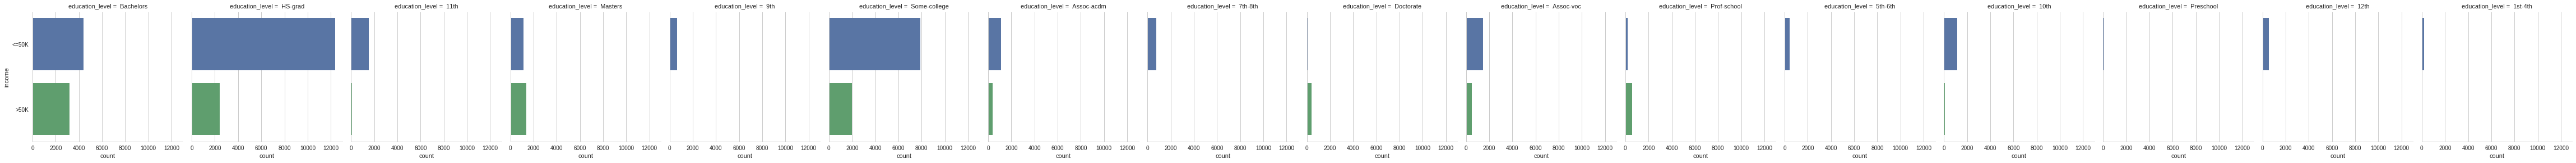

In [43]:
# importance education-level
sns.factorplot(y="income",
               col="education_level", data=data, kind="count")

### Conclusion on importance of education-level###
****
* Looking at the plot it's clear that if a person has certain education_level, then only it can belong to >50K category
* Important feature

******

# 10. exploring importance of relationship#
we would be looking at following graphs
* frequency plot of each marital status for each income group

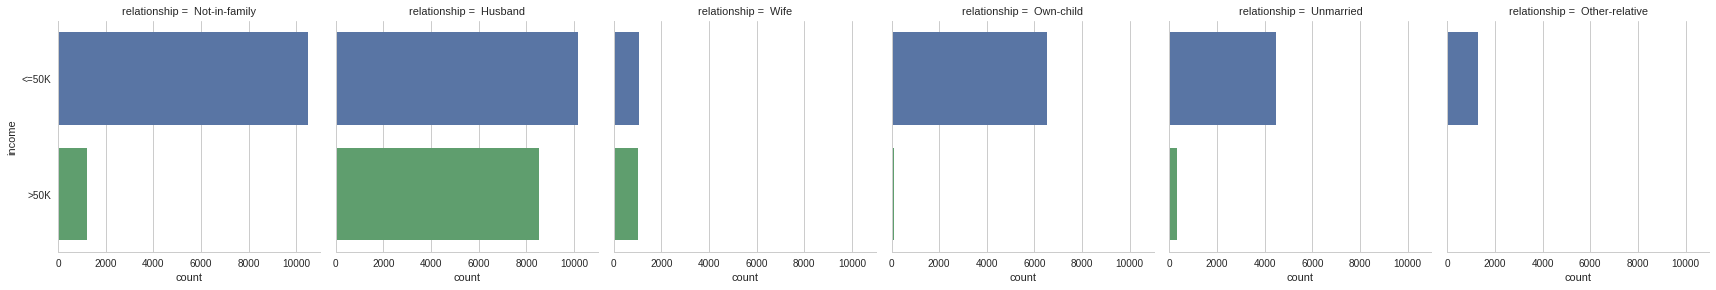

In [44]:
# importance of relationship
sns.factorplot(y="income",
               col="relationship", data=data, kind="count")

### Conclusion on importance of relationship###
****
* This feature is important as looking at graph, People that are either husband or wife have higher chance of belonging to >50k category
* Important feature


******

# 11. exploring importance of race#
we would be looking at following graphs
* frequency plot of each marital status for each income group

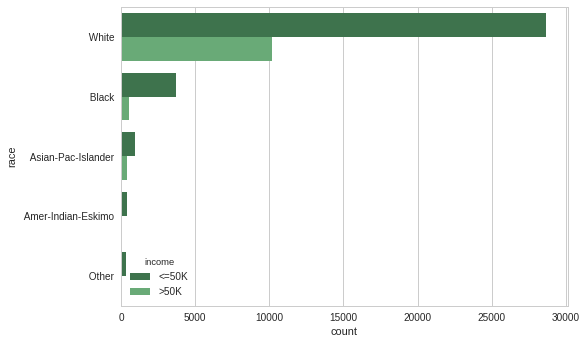

In [36]:
sns.countplot(y="race", hue="income", data=data, palette="Greens_d")

### Conclusion on importance of race###
****
* looking at graph, no particular value of this feature provides classification advantage
* not important feature
******

# 12. exploring importance of sex#
we would be looking at following graphs
* frequency plot of each marital status for each income group

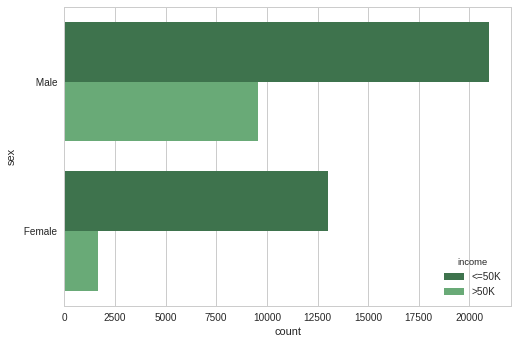

In [35]:
# importance of sex
sns.countplot(y="sex", hue="income", data=data, palette="Greens_d")

### Conclusion on importance of sex###
*****
* no classification advantage as for both sexes the distribution is almost same
* not important feature
******

# 13. exploring importance of native-country#
we would be looking at following graphs
* frequency plot of each marital status for each income group

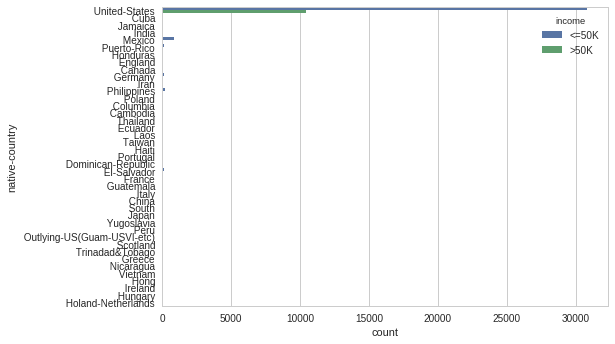

In [34]:
# importance of native-country
sns.countplot(y='native-country',hue='income',data=data)


### Conclusion on importance of native-country###
****
* Vast majority of sample points of both classes are Americans. Therefore this feature won't provide any classification advantage
* not Important feature

******


**Answer:**
#### Important features based on data exploration (ordered rank-wise):
1. **Capital-Gain**: As highlighted in exploration done above, Capital gain values create a workable split between the 2 classes of income groups. Capital gain values can be used to single out >50K samples
2. **Capital-Loss** : Like capital-gain, >50K class and <50K class have high difference in capital loss values
3. **Education-number** : While exploring data it was found that education number and education level played an  important role in deciding income class. Looking at education_num variable, A splitting based on this value looked possible. values greater than 10 were generally high income group. And lower ones low income group. 
Education_level is also important feature, but looking at the quality of split created by it Education_num feature looks better
4. **Marital-status** : In exploration done above Relationship and Marital_Status were highlighted important. Married people living with spouse had higher chance of belonging to higher income group. This feature though can't create split alone, but it can be used in conjunction with other features to create good classification
5. **Age** : In exploration chart for Age, it is clearly visible that Higher value of age increses chances of belonging to higher income group.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

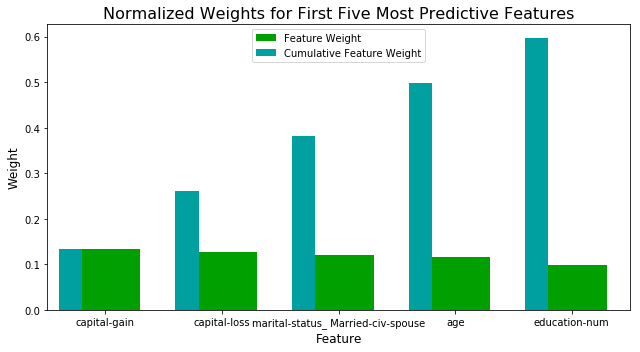

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Train the supervised model on the training set
clf = GradientBoostingClassifier(random_state=rand)
model = clf.fit(X_train,y_train)

# TODO: Extract the feature importances
importances = model. feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**
#### How do these five features compare to the five features you discussed in Question 6? 
All five features chosen in question 6 correspond  to the 5 features produced above. 

#### If you were close to the same answer, how does this visualization confirm your thoughts?
This visualisation, shows that about 60% predictive capability is hidden in these 5 Features. The data exploration done above was also indicative of the same fact, where I found thatThese % features contributed to creating a split in data based on income level 



### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [52]:
# Import functionality for cloning a model
#from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = GradientBoostingClassifier(learning_rate=0.05,n_estimators=1500, min_samples_split = 210,
                                 max_depth=6,min_samples_leaf=50,subsample=1,random_state=rand)

clf = clf.fit(X_train_reduced,y_train)
# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8712
F-score on testing data: 0.7524

Final Model trained on reduced data
------
Accuracy on testing data: 0.8583
F-score on testing data: 0.7234


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**
#### How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used? ####
* Final Model trained on full data
    * Accuracy on testing data: 0.8712
    * F-score on testing data: 0.7524

* Final Model trained on reduced data
    * Accuracy on testing data: 0.8583
    * F-score on testing data: 0.7234

* F-beta score has reduced by 0.03
* accuracy has reduced by 1.5%

##### If training time was a factor, would you consider using the reduced data as your training set? #####
Yes, i training time was one of constraints I would choose a reduced data as my training set



> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.